# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)

2.14.0


In [2]:
K = tf.keras.backend

In [3]:
import os
import json
from glob import glob

In [4]:
from matplotlib import pyplot as plt
from datetime import datetime
import random
from random import shuffle

In [5]:
cur_path = '/content'

dirs_list = ['/data', '/output', '/data/boxes']

In [6]:
for cur_dir in dirs_list:
    path_data = cur_path + cur_dir
    if not os.path.exists(path_data):
        os.makedirs(path_data)

In [7]:
# cur_path = '/content'
# path_data = cur_path + '/data'
# if not os.path.exists(path_data):
#   os.makedirs(path_data)

In [8]:
# cur_path, path_data

In [9]:
# cur_path = os.getcwd()
# path_data = cur_path + '/output'
# if not os.path.exists(path_data):
#   os.makedirs(path_data)

In [10]:
# path_labels = cur_path + '/data/boxes'
# if not os.path.exists(path_labels):
#   os.makedirs(path_labels)

In [11]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=42d03beea58838903613f8be62126b3ba59da098e76366d3c8af2198082dcbda
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [12]:
import wget

In [13]:
downloadsFolder = '/content/data/boxes'
if not os.listdir(downloadsFolder):
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5458/bet_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5459/shark_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5460/dol_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5461/yft_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5462/alb_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147157/5463/lag_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/147332/5471/other_labels.json', out = '/content/data/boxes')
    wget.download('https://storage.googleapis.com/kaggle-forum-message-attachments/158691/5864/NoF_labels.json', out = '/content/data/boxes')
else:
    print('Files already exists')


'/content/data/boxes/NoF_labels.json'

## Загрузим данные с Kaggle

In [32]:
from fish_dataset_from_kaggle_v5 import download_dataset

In [33]:
download_dataset()

In [34]:
!unzip -qo /content/data/the-nature-conservancy-fisheries-monitoring.zip -d /content/data
!unzip -qo /content/data/train.zip -d /content/data
!unzip -qo /content/data/test_stg1.zip -d /content/data

# /content/data/the-nature-conservancy-fisheries-monitoring.zip

## Функцию отрисовки рамки я не менял

In [35]:
TRAIN_PREFIX = '/content/data/train'

def draw_boxes(annotation, rectangles = None, image_size = None):

    def _draw(img, rectangles, scale_x, scale_y, color = (0, 255, 0)):

        for rect in rectangles:

            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness = 4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

## Формируем словарь классов рыб

Переводим метки в верхний регистр

In [36]:
for path in glob('/content/data/boxes/*.json'):
        old_name = os.path.basename(path).split('_', 1)
        dirname = os.path.dirname(path)

        filename_new = old_name[0].upper() + '_' + old_name[1]
        path_new = os.path.join(dirname, filename_new)
        os.rename(path, path_new)


In [38]:
labels_list = {}
for path in glob('/content/data/boxes/*.json'):
        label = (os.path.basename(path).split('_', 1)[0])
        labels_list[label] = 0
        # print(label)

labels_list = dict(sorted(labels_list.items()))

In [39]:
print(labels_list)

{'ALB': 0, 'BET': 0, 'DOL': 0, 'LAG': 0, 'NOF': 0, 'OTHER': 0, 'SHARK': 0, 'YFT': 0}


In [40]:
len(labels_list)

8

## Переделываем папки меток рыб в верхний регистр

In [41]:
from genericpath import isfile
dir = '/content/data/train/'

for i in os.walk(dir):
  dir_split = i[0].split('train/')
  if dir_split[1] != '':
    old_dir = os.path.join(dir, dir_split[1])
    new_dir = os.path.join(dir, dir_split[1].upper())
    if os.path.exists(new_dir):
      print('file exists, ', new_dir)
    else:
      os.rename(old_dir, new_dir)

file exists,  /content/data/train/YFT
file exists,  /content/data/train/DOL
file exists,  /content/data/train/ALB
file exists,  /content/data/train/OTHER
file exists,  /content/data/train/SHARK
file exists,  /content/data/train/LAG
file exists,  /content/data/train/BET


In [42]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [43]:
!p7zip -d /content/data/test_stg2.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/data/                        1 file, 1152137421 bytes (1099 MiB)

Extracting archive: /content/data/test_stg2.7z
--
Path = /content/data/test_stg2.7z
Type = 7z
Physical Size = 1152137421
Headers Size = 82081
Method = LZMA:25
Solid = +
Blocks = 1

  0%      0% - test_stg2/image_00001.jpg                                  0% 38 - test_stg2/image_00039.jpg                                     0% 80 - test_stg2/image_00081.jpg                                     1% 125 - test_stg2/image_

In [44]:
directory = ['/content/data/test_stg1', '/content/data/test_stg2']

for cur_dir in directory:
    lst = os.listdir(cur_dir)
    print(f'number of files in directory {cur_dir}  = {len(lst)}')

number of files in directory /content/data/test_stg1  = 1000
number of files in directory /content/data/test_stg2  = 12153


# Загружаем разметку

В загружаемые данные добавлена информация о классе рыбы в формате словаря, где 1 - стоит там, где рыба классифицированна как принадлежащая данному классу, в остльных - 0

In [ ]:
# index = list(labels_list.keys()).index('LAG')

In [ ]:
# index

In [45]:
def load_annotations(labels_list):
    boxes = dict()
    for path in glob('/content/data/boxes/*.json'):
        label = (os.path.basename(path).split('_', 1)[0])
        label_index = list(labels_list.keys()).index(label)
        label_vec = np.zeros(8)
        label_vec[label_index] = 1

        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label, basename)
                annotation['fish_type'] = label_vec
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
                else:
                  print('No such file ', annotation['filename'])
    return dict(sorted(boxes.items()))

In [46]:
boxes = load_annotations(labels_list)  # загружаем разметку детекций

In [47]:
labels_list.keys()

dict_keys(['ALB', 'BET', 'DOL', 'LAG', 'NOF', 'OTHER', 'SHARK', 'YFT'])

In [48]:
boxes.keys()

dict_keys(['ALB', 'BET', 'DOL', 'LAG', 'NOF', 'OTHER', 'SHARK', 'YFT'])

In [49]:
boxes['LAG'][0]

{'annotations': [{'class': 'rect',
   'height': 308.0000000000008,
   'width': 398.0000000000009,
   'x': 790.0000000000019,
   'y': 325.0000000000008},
  {'class': 'rect',
   'height': 224.0000000000005,
   'width': 366.0000000000008,
   'x': 861.000000000002,
   'y': 607.0000000000015}],
 'class': 'image',
 'filename': '/content/data/train/LAG/img_07919.jpg',
 'fish_type': array([0., 0., 0., 1., 0., 0., 0., 0.])}

### Визуализируем разметку

In [50]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,ALB,1719
1,BET,200
2,DOL,117
3,LAG,67
4,NOF,465
5,OTHER,299
6,SHARK,176
7,YFT,734


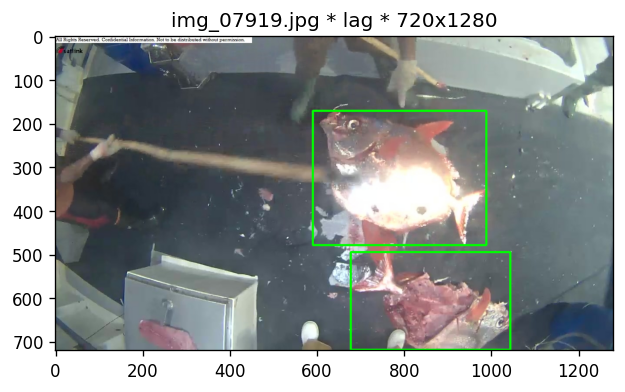

In [51]:
annotation = boxes['LAG'][0]
img = draw_boxes(annotation)

plt.figure(figsize = (6, 6), dpi=120)
plt.imshow(img)

plt.title('{} * {} * {}x{}'.format(
    annotation['filename'].split('/')[-1], 'lag', img.shape[0], img.shape[1]));

### Распределение размеров разметки

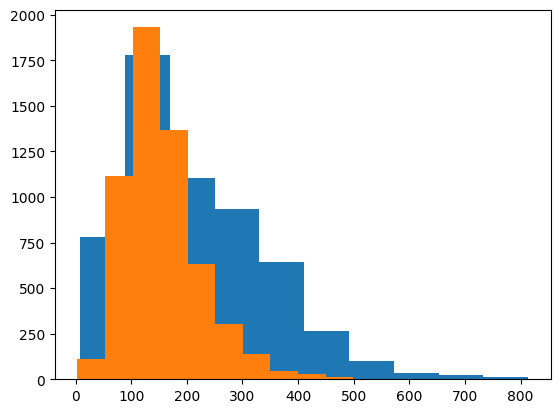

In [52]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

# Экстрактор признаков

In [53]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top = False,
                       input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58889256/58889256 [==============================] - 2s 0us/step
(None, 23, 37, 512)


In [54]:
features.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0     

# Сетка якорей (anchor grid)

In [55]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [56]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w = ANCHOR_WIDTH, anchor_h = ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

## в данную функцию добавлена загрузка типа рыб

In [57]:
def encode_anchors(fish_type, annotation, img_shape, iou_thr=0.5):
    num_classes = 8
    rect_shape = 4
    fish_presence = 1
    dimensions = num_classes + rect_shape + fish_presence
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], dimensions), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            anchors_np = np.array([dx, dy, dw, dh, 1.])

            encoded[row, col] = np.concatenate([fish_type, anchors_np])
# ---------------- объединяю вектор типа рыбы (8 значений - 0, рыба не относится к данному типу, 1 - относится) с данными о прямоугольнике
# ---------------- также дотавляю последним элементом вектора признак наличия рыбы 1 (рыба есть)

    return encoded

def _sigmoid(x):
    return K.sigmoid(x)

# ----------------- добавил функцию софтмакс для мультиклассовой классификации -----------------------
def _softmax(x):

    if len(x.shape) == 1:
      x = K.reshape(x, (-1,len(x)))

    x_soft = K.softmax(x)

    return x_soft

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
# ---------- в logit загружаю вектор классов -----------------------------------------
            logit = prediction[row, col][:8]

            dx, dy, dw, dh = prediction[row, col][8:12]
# ---------- в fish_class загружаю признак наличия рыбы ------------------------------
            fish_class = prediction[row, col][12]
            conf = _sigmoid(fish_class)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'class': logit})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold = 0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]

    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

In [58]:
annotation = boxes['LAG'][0]

In [59]:
annotation

{'annotations': [{'class': 'rect',
   'height': 308.0000000000008,
   'width': 398.0000000000009,
   'x': 790.0000000000019,
   'y': 325.0000000000008},
  {'class': 'rect',
   'height': 224.0000000000005,
   'width': 366.0000000000008,
   'x': 861.000000000002,
   'y': 607.0000000000015}],
 'class': 'image',
 'filename': '/content/data/train/LAG/img_07919.jpg',
 'fish_type': array([0., 0., 0., 1., 0., 0., 0., 0.])}

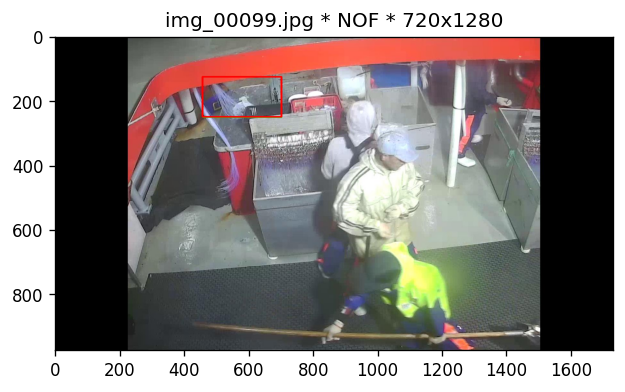

In [60]:
annotation = boxes['NOF'][10]
fish_type = labels_list.copy()
fish_type['NOF'] = 1

encoded = encode_anchors(np.array(list(fish_type.values())),
                         annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr = 0.5)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize = (6, 6), dpi = 120)
plt.imshow(draw_boxes(annotation, decoded))

index = decoded[0]['class'].argmax()
fish_class = list(labels_list.keys())[index]

plt.title('{} * {} * {}x{}'.format(
    annotation['filename'].split('/')[-1], fish_class, img.shape[0], img.shape[1]));

## Функция потерь

## У меня нейронная сеть на выходе дает вектор, который включает 23х37х13, где 13 измерений, из которых 8 - по кол-ву классов рыбы, 4 - по прямоугольнику, 1 класс - признак рыбы

In [61]:
K = tf.keras.backend

def confidence_loss_categorical(y_true, y_pred):

# ----------------- делаю расчет функции потерь для мультиклассовой классификации -------------------------------------------------------------

    conf_loss = K.categorical_crossentropy(y_true, y_pred, from_logits = True)

    return conf_loss

def confidence_loss_binary(y_true, y_pred):

    conf_loss = K.binary_crossentropy(y_true, y_pred, from_logits = True)

    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true - y_pred)
    square_loss = 0.5 * K.square(y_true - y_pred)
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)

    smooth_l1_loss = K.sum(total_loss, axis =- 1)

    return smooth_l1_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции

    y_true = K.reshape(y_true, (batch_size, -1, 13))
    y_pred = K.reshape(y_pred, (batch_size, -1, 13))

# ---------------------- загружаю данные ----------------------------------------------------
    y_pred_fish_type = y_pred[..., :8]
    y_true_fish_type = y_true[..., :8]

    y_pred_rect = y_pred[..., 8:12]
    y_true_rect = y_true[..., 8:12]

    y_pred_fish_presence = y_pred[..., 12]
    y_true_fish_presence = y_true[..., 12]

# ------------------------------------------------------------------------------ ------------

    conf_loss_binary = confidence_loss_binary(y_true_fish_presence, y_pred_fish_presence)

    conf_loss_categorical = confidence_loss_categorical(y_true_fish_type, y_pred_fish_type)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true_rect, y_pred_rect)

    # positive examples loss
    pos_conf_loss_binary = K.sum(conf_loss_binary * y_true_fish_presence, axis = -1)
    pos_conf_loss_categorical = K.sum(conf_loss_categorical * y_true_fish_presence, axis = -1)
    pos_loc_loss = K.sum(loc_loss * y_true_fish_presence, axis = -1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true_fish_presence[..., 0], axis = -1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss_binary * (1. - y_true_fish_presence), k = K.cast(num_neg, 'int32'))
    neg_conf_loss = K.sum(neg_conf_loss, axis = -1)

    total_loss = pos_loc_loss + pos_conf_loss_binary + neg_conf_loss + pos_conf_loss_categorical

    return total_loss

## Загрузка данных

In [62]:
from random import shuffle

def load_img(path, target_size = (IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size = 32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов

                y.append(encode_anchors(boxes[j]['fish_type'], boxes[j], img_shape))
                X.append(img)

            yield np.array(X), np.array(y)

## Добавляем выход детектора

In [63]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(13, # ---------------  добавил еще 6 выходов (вместо одного), чтобы было 6 классов рыб, итого 11 (x,y,w,h + 6 классов рыб + 1 признак наличия рыбы)
                                kernel_size=(1, 1),
                                activation = 'linear',
                                kernel_regularizer = 'l2')(output)

model = tf.keras.models.Model(inputs = features.inputs, outputs = output)
# model.summary()

In [64]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 750, 1200, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 750, 1200, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 750, 1200, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 375, 600, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 375, 600, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 375, 600, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 187, 300, 128)     0     

## Обучение

In [65]:
adam = tf.keras.optimizers.Adam(learning_rate = 3e-4)
model.compile(optimizer = adam,
              loss = total_loss,
              metrics = [confidence_loss_categorical])

In [66]:
if os.path.isfile('/content/output/fishdetector.hdf5') == True:
    model.load_weights('/content/output/fishdetector.hdf5')
else:
    print('file not found')

file not found


In [ ]:
# os.getcwd()

In [ ]:
# os.chdir('/content/output')

In [ ]:
batch_size = 7

gen = data_generator(boxes, batch_size = batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/output/fishdetector.hdf5',
    monitor = 'loss',
    verbose = 1,
    save_best_only =True,
    save_weights_only =False,
    mode = 'auto',
    save_freq = 10)

history = model.fit(gen,
                    steps_per_epoch = steps_per_epoch,
                    epochs = 25,
                    callbacks = [checkpoint])

Epoch 1/25
  9/539 [..............................] - ETA: 6:22 - loss: 28.0954 - confidence_loss_categorical: 0.0248
Epoch 1: loss improved from inf to 26.54302, saving model to /content/output/fishdetector.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 19/539 [>.............................] - ETA: 6:30 - loss: 19.4974 - confidence_loss_categorical: 0.0179
Epoch 1: loss improved from 26.54302 to 19.13032, saving model to /content/output/fishdetector.hdf5
 29/539 [>.............................] - ETA: 6:24 - loss: 16.3454 - confidence_loss_categorical: 0.0158
Epoch 1: loss improved from 19.13032 to 16.32100, saving model to /content/output/fishdetector.hdf5
 39/539 [=>............................] - ETA: 6:24 - loss: 14.8479 - confidence_loss_categorical: 0.0148
Epoch 1: loss improved from 16.32100 to 14.72579, saving model to /content/output/fishdetector.hdf5
 49/539 [=>............................] - ETA: 6:17 - loss: 13.9000 - confidence_loss_categorical: 0.0148
Epoch 1: loss improved from 14.72579 to 13.74848, saving model to /content/output/fishdetector.hdf5
 59/539 [==>...........................] - ETA: 6:09 - loss: 13.0638 - confidence_loss_categorical: 0.0148
Epoch 1: loss improved from 13.74848 to 13.05531, saving model to

In [ ]:
if os.path.isfile('/content/output/history_loss.csv') == True:
    history_full = pd.read_csv('/content/output/history_loss.csv')
    history_full = history_full['loss'].tolist()
else:
    history_full = []

In [ ]:
history_full += history.history['loss']

In [ ]:
# history_df = pd.DataFrame(history.history['loss'], columns = ['loss'])

In [ ]:
# history_df.to_csv('history_loss.csv', index = False)

In [ ]:
plt.plot(history_full)

## Результат работы детектора

In [ ]:
def find_th(pred):
  fish_sign = pred[...,12]
  fish_sign = K.reshape(fish_sign, (-1, 1))

  fish_sign_sigm = _sigmoid(fish_sign)
  fish_sign_sigm_max = np.max(fish_sign_sigm)

  delta = 0.05
  ind_num = 1
  i = 0
  while ind_num < 2:

    th = fish_sign_sigm_max * (1 - i*delta)
    fish_ind = tf.where(fish_sign_sigm > fish_sign_sigm_max * (1 - i*delta)).numpy()
    ind_num = len(fish_ind[:,0])
    i += 1

  return th

In [ ]:
def samples_generator(boxes, fish_types_number, samples_number):

  fish_type = []
  pic_number = []
  total_fish_types = 8

  if fish_types_number == total_fish_types:
    rand_list = list(range(0, total_fish_types))
  else:
    rand_list = random.sample(range(0, total_fish_types), fish_types_number)


  for i in rand_list:
    for j in range(samples_number):
      fish_type.append(list( boxes.keys() )[i])
      pic_number.append( random.randint( 0, len( boxes[fish_type[-1]] ) - 1 ) )

  return pic_number, fish_type

In [ ]:
def show_results(boxes, num_classes, num_samples_per_class, show_charts = True):

    pics_numbers, fish_types = samples_generator(boxes, num_classes, num_samples_per_class)

    df = []
    decode_ok = 0
    decode_failed = 0

    for i, j in zip(pics_numbers, fish_types):
      annotation = boxes[j][i]

      _, sample_img = load_img(annotation['filename'])
      pred = model.predict(np.array([sample_img,]))

      decoded = decode_prediction(pred[0], conf_thr = 0.7)

      if len(decoded) == 0:
          print('base prediction failed (conf_thr = 0.7), file name', annotation['filename'].split('/')[-1])
          conf_thr = find_th(pred)
          print('new conf_thr = ', conf_thr)
          decoded = decode_prediction(pred[0], conf_thr)
          decode_failed += 1
      else:
          decode_ok += 1


      decoded_non_max = non_max_suppression(decoded,
                                            max_output_size = 5,
                                            iou_threshold = 0.7)

      img = draw_boxes(annotation, decoded_non_max, (IMG_WIDTH, IMG_HEIGHT))

      label_true_index = np.argmax(annotation['fish_type'])
      label_true_name = list(labels_list.keys())[label_true_index]
      label_predicted_index = np.argmax(_softmax(decoded_non_max[0]['class']))
      label_predicted_name = list(labels_list.keys())[label_predicted_index]

      df.append([annotation['filename'], label_true_index, label_predicted_index, label_true_name, label_predicted_name])

      if show_charts == True:

              plt.figure(figsize = (6, 6), dpi =120)
              plt.imshow(img)
              plt.title('{} / {} - {} / {} - {}'.format(
                                                        annotation['filename'].split('/')[-1],
                                                        'label_true ',
                                                        label_true_name,
                                                        'label predicted ',
                                                        label_predicted_name
                                                    )
                      )

    df = pd.DataFrame(df, columns = ['image', 'label_true_index', 'label_predicted_index', 'label_true_name', 'label_predicted_name'])
    print('share of failed decoded = ', decode_failed/(decode_ok + decode_failed))


    return df

In [ ]:
show_results(boxes, 8, 1)

In [ ]:
df = show_results(boxes, 8, 10, show_charts = False)

In [ ]:
df['check'] = (df['label_true_name'] == df['label_predicted_name'])

In [ ]:
df [df['check'] == False]

## Делаем предсказание на тесте

In [ ]:
test_labels_list = []
test_files_list = []
FISH_CLASSES = list(labels_list.keys())
decode_failed = 0
decode_ok = 0

test_dirs_list = ['/content/data/test_stg1/*.jpg', '/content/data/test_stg2/*.jpg']

num_files = 0

path_prefix = '/content/output/'

start = datetime.now()

for cur_dir in test_dirs_list:

    test_images = glob(cur_dir)

    for i, filename in enumerate(test_images):
        _, sample_img = load_img(filename)
        pred = model.predict(np.array([sample_img,]), verbose = 0)

        decoded = decode_prediction(pred[0], conf_thr = 0.7)

        if len(decoded) == 0:
            conf_thr = find_th(pred)
            decoded = decode_prediction(pred[0], conf_thr)
            decode_failed += 1
        else:
            decode_ok += 1


        decoded_non_max = non_max_suppression(decoded,
                                              max_output_size = 5,
                                              iou_threshold = 0.7)

        fish_type = _softmax(decoded_non_max[0]['class']).numpy()
        fish_type = (np.reshape(fish_type, -1)).tolist()

        test_labels_list.append(fish_type)
        filename_short = filename.split('/')[-2] + '/' + filename.split('/')[-1]
        test_files_list.append(filename_short)

        if (num_files % 1000 == 0) & (num_files > 0):
            now = datetime.now()
            time_proceed = round((now-start).seconds/60,1)
            print('files saved = ', num_files, ' time proceed (min) = ', time_proceed)
            print(num_files, num_files % 1000)
            start = now

            filename = path_prefix + 'submission_fish_' + str(num_files) + '.csv'
            submission = pd.DataFrame(test_labels_list, columns = FISH_CLASSES)
            submission.insert(0, 'image', test_files_list)
            submission.to_csv(filename, index = False,  float_format = '%.4f')

        num_files += 1

submission = pd.DataFrame(test_labels_list, columns = FISH_CLASSES)
submission.insert(0, 'image', test_files_list)

print(f'Share of failed decoded pictures = {decode_failed/decode_ok*100:.2f}%')

print('Total files = ', num_files)


files saved =  1000  time proceed (min) =  14.8
1000 0
files saved =  2000  time proceed (min) =  15.8
2000 0
files saved =  3000  time proceed (min) =  15.8
3000 0
files saved =  4000  time proceed (min) =  15.7
4000 0
files saved =  5000  time proceed (min) =  15.7
5000 0
files saved =  6000  time proceed (min) =  15.6
6000 0
files saved =  7000  time proceed (min) =  15.8
7000 0
files saved =  8000  time proceed (min) =  15.8
8000 0


In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   12 non-null     object 
 1   ALB     12 non-null     float64
 2   BET     12 non-null     float64
 3   DOL     12 non-null     float64
 4   LAG     12 non-null     float64
 5   NOF     12 non-null     float64
 6   OTHER   12 non-null     float64
 7   SHARK   12 non-null     float64
 8   YFT     12 non-null     float64
dtypes: float64(8), object(1)
memory usage: 992.0+ bytes


In [ ]:
submission.head(10)

,image,ALB,BET,DOL,LAG,NOF,OTHER,SHARK,YFT
0,test_stg1/img_01035.jpg,1.102241e-03,2.280206e-08,9.085277e-15,2.462376e-05,2.623008e-17,2.078676e-11,9.988731e-01,1.337864e-08
1,test_stg1/img_00697.jpg,3.642206e-29,5.813281e-11,9.235382e-10,2.691071e-02,5.186087e-06,1.782296e-28,9.730840e-01,3.220729e-10
2,test_stg1/img_00914.jpg,1.031480e-03,6.960027e-05,1.842964e-13,3.849341e-05,6.621625e-12,2.900351e-10,9.988604e-01,1.129224e-12
3,test_stg1/img_01976.jpg,4.622891e-05,1.343141e-12,1.297116e-02,4.339125e-10,9.948904e-11,3.655857e-05,9.869460e-01,7.799830e-11
4,test_stg1/img_05813.jpg,7.902279e-14,2.170192e-14,1.407334e-17,7.073420e-06,3.233455e-13,7.685431e-11,3.956750e-17,9.999930e-01
5,test_stg1/img_05349.jpg,6.864097e-14,1.068467e-20,2.422206e-06,2.534894e-10,2.974698e-09,1.200932e-06,4.425380e-08,9.999963e-01
6,test_stg2/image_09250.jpg,3.453133e-04,2.763532e-20,4.901186e-05,1.133056e-07,1.208797e-18,4.717966e-09,1.973229e-10,9.996056e-01
7,test_stg2/image_00651.jpg,1.247157e-15,6.216578e-07,2.373475e-10,1.491888e-08,1.291267e-08,2.644784e-10,9.999994e-01,1.955847e-11
8,test_stg2/image_02085.jpg,2.801888e-09,4.882383e-09,4.855165e-05,9.972096e-01,1.536746e-04,6.774315e-06,2.477046e-03,1.044055e-04
9,test_stg2/image_07245.jpg,6.107170e-06,1.483744e-08,1.066381e-12,2.278653e-08,1.580915e-14,1.702744e-05,4.336968e-06,9.999725e-01


In [ ]:
submission.to_csv('/content/output/submission_fish.csv', index = False,  float_format='%.4f')

In [ ]:
# os.system('kaggle competitions submit -c the-nature-conservancy-fisheries-monitoring -f submission_fish.csv')

In [ ]:
# !kaggle competitions submit -c the-nature-conservancy-fisheries-monitoring -f submission_fish.csv